In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google.colab import drive


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# TEXT PREPROCESSING

In the following we've defined a function that applies some text pre processing techniques.


1.   Transform to lowercase
2.   Remove the HTML tags
3.   Tokenization
4.   Stopwords removal
5.   Remove the punctuation marks



In [16]:
#Creation of a list of reviews, each review will be tokenized considering a word
# as a token.
def preprocess_review(review_list):

  #regex to remove HTML tags
  html_removal = re.compile('<.*?>')

  cleaned_reviews = []
  for review in review_list:
      #each review must be converted to lowercase
      lower_review = review.lower()

      #remove the html tags
      nohtml_review = re.sub(html_removal, ' ', lower_review)

      #tokenized the review using the word_tonkenize
      tokenized_review = word_tokenize(nohtml_review)

      #stopwords removal
      nostopwords_review = []

      #for each token, check if the token is inside the list of stopwords
      # for token in tokenized_review:
      #     if token not in stopwords_en:
      #         #append the ones not in the list of stopwords
      #         nostopwords_review.append(token)
      nostopwords_review = [token for token in tokenized_review if token not in stopwords_en]

      #remove punctuation #1
      #remove a token only if it is composed by a single punctuation mark
      #nopunctuation_review = [token for token in nostopwords_review if token not in string.punctuation]

      #remove punctuation #2
      #remove tokens composed entirely by punctuation marks
      nopunctuation_review = [token for token in nostopwords_review if not all(char in string.punctuation for char in token)]

      #remove punctuation #3 #we don't need to use tagging for punctuation!
      # pos_tagging = nltk.pos_tag(nostopwords_review)
      # nopunctuation_review = [tuple for tuple in pos_tagging if len(tuple[1]) > 1 ]

      cleaned_reviews.append(' '.join(nopunctuation_review))

  return cleaned_reviews

The following two function are used to load and store the cleaned list of reviews. These functions will be useful to load from Drive the dataset when we've to build the batches of reviews (the input of the summarizer).

In [ ]:
#Function to write the list into a file
def write_list_to_file(filename, list):
  #Opening a file in 'w' mode clears its content
  file = open(filename,'w')
  for item in list:
    file.write(item+"\n")
  file.close()

In [9]:
#Function to read a list from a file
def read_list_from_file(filename):
  result = []
  # opening the file in read mode
  my_file = open(filename, "r")

  # reading the file
  data = my_file.read()

  # replacing end splitting the text
  # when newline ('\n') is seen.
  data_into_list = data.split("\n")
  my_file.close()

  return data_into_list

Mount Drive

In [4]:
#Mount Google Drive to access the shared folder
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset from the csv file, the bad lines are skipped and the null values are removed.

In [ ]:
#Load the dataset as csv, skipping the bad lines
csv = pd.read_csv("drive/Shareddrives/BPM PROJECT/Dataset/amazon_reviews_reduced.csv", on_bad_lines="skip")

#Drop the null values
csv.dropna(inplace=True)

#Check the number of the reviews for each product in the reduced dataset
csv_grouped = csv.groupby(by="product_id").count().sort_values(by="review_body")
csv_grouped

,Unnamed: 0,marketplace,customer_id,review_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
product_id,,,,,,,,,,,,,,,
B0001FTVEK,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792,8792
B0012S4APK,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358,9358
B003EM8008,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766,9766
B0002L5R78,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166,11166
B003L1ZYYM,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333,15333


We're using a subset of the starting dataset for simplicity, in particular it formed by the reviews of the 5 products with the highest number of reviews.

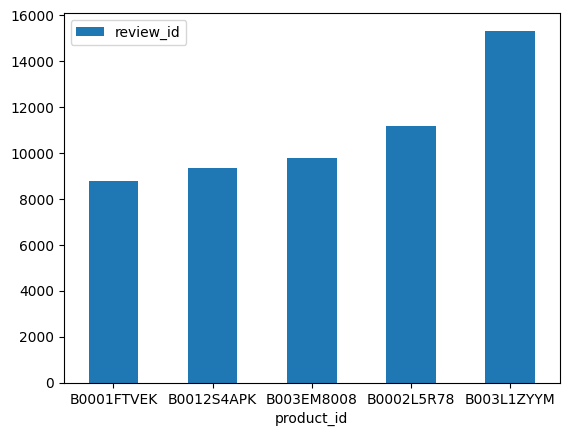

In [ ]:
ax = csv_grouped.plot.bar(y='review_id', rot=0)

# Dataset creation

For the test of the models we'll use just the reviews of the product with product_id **B003L1ZYYM**, the features that we use are just the **review_body** and **review_headline**, the latter is used as label during the fine tuning process.

In [ ]:
csv_r = csv[csv["product_id"] == "B003L1ZYYM"]
csv_r = csv_r[["review_body", "review_headline"]]
csv_r.reset_index(inplace=True, drop=True)

In [ ]:
csv_r.to_csv('drive/Shareddrives/BPM PROJECT/Dataset/amazon_reviews_reduced_preprocessed.csv', index=False)

In [13]:
#TEST
csv_r = pd.read_csv("drive/Shareddrives/BPM PROJECT/Dataset/amazon_reviews_reduced_preprocessed.csv", on_bad_lines="skip")
#OK

In order to test the models we need a sample of the reviews, we select the last 1000 reviews to form the list.

In [14]:
#Sample the reviews to be summarized
review_list = csv_r["review_body"].tail(1000).tolist()

In [17]:
#Preprocess the list
review_list = preprocess_review(review_list)

In [7]:
#Filename for the review list's file
filename_review_list = "drive/Shareddrives/BPM PROJECT/Dataset/review_list.txt"

In [ ]:
#Save the list to the disk
write_list_to_file(filename_review_list, review_list)

In [10]:
#Check if the list was correctly written
res = read_list_from_file(filename_review_list)

In [ ]:
#Check if thw two lists are the same list
all(x == y for x, y in zip(review_list, res))
#OK they were the same list!

True

# Analyzing the reviews composition

In [18]:
#Dict containing the number of tokens as key and the number of reviews having
# such a number of tokens
lengths = dict()
for review in review_list:
  length = len(review.split(" "))
  if length in lengths:
    lengths[length] += 1
  else:
    lengths[length] = 1

#Sort in increasing number of keys
sorted_lengths = dict(sorted(lengths.items()))

<BarContainer object of 112 artists>

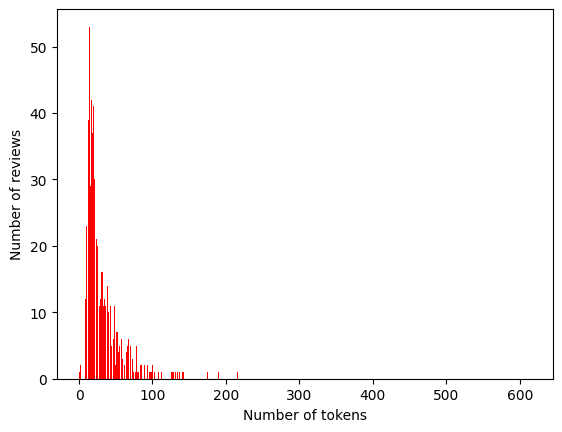

In [19]:
plt.xlabel ('Number of tokens')
plt.ylabel ('Number of reviews')
plt.bar(sorted_lengths.keys(), sorted_lengths.values(), color='r')

In [20]:
#Cut the extremes
lengths2 = sorted_lengths #Sicuramente sto assegnando lo stesso oggetto
del lengths2[614]
del lengths2[1]
del lengths2[2]
del lengths2[4]

<BarContainer object of 108 artists>

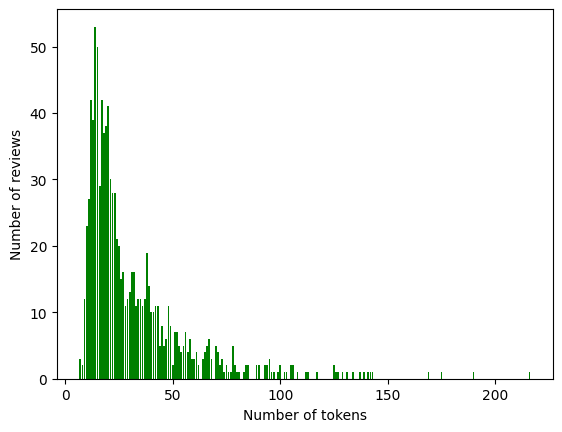

In [21]:

plt.xlabel ('Number of tokens')
plt.ylabel ('Number of reviews')
plt.bar(lengths2.keys(), lengths2.values(), color='g')

In [22]:
print("(number of tokens: {}, number of reviews: {})".format(max(lengths2, key= lambda x: lengths2[x]), lengths2[max(lengths2, key= lambda x: lengths2[x])]))

(number of tokens: 14, number of reviews: 53)


In [23]:
total = 0
#Sum the lengths of the reviews
for review in review_list:
  total += len(review.split(" "))

#Divide by the total number of reviews
avg = total / len(review_list)

#We're considering the dataset without extremes!
print("Avg length without extremes: {}".format( avg) )

Avg length without extremes: 32.107
